Description: This script creates a two panel plot with one subplot showing the histogram of total and CG flash flash rates in the Edmond-Carney storm. The second subplot shows application of lightning jump algorithm as per Schultz et al. (2015)

In [1]:
import netCDF4 as ncdf
from lmatools.vis.multiples_nc import centers_to_edges
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pyart
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
# from mayavi import mlab
# from tvtk.util.ctf import PiecewiseFunction
from numpy import *
from netCDF4 import num2date, date2num, Dataset
import glob
import sys
import os
import pandas as pd
from pyart.graph import common
import math
from numpy import ones, vstack
from numpy.linalg import lstsq
import warnings
from datetime import datetime
from datetime import timedelta
import tables
import pandas
from matplotlib import colors
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
from netCDF4 import num2date, date2num, Dataset

warnings.filterwarnings("ignore")

matplotlib.rc('xtick', labelsize=21)
matplotlib.rc('ytick', labelsize=21)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def time2sec(f):
    date_start = datetime.strptime(
        f"{f.split('/')[-1].split('_')[2]}", '%H%M%S')
    interval_left = timedelta(
        hours=date_start.hour, minutes=date_start.minute, seconds=date_start.second).total_seconds()
    for i in range(600):
        interval_right = interval_left + 60
        yield[interval_left, interval_right]
        interval_left = interval_right


def extent_of_interest(f):
    parts = f.split('/')

    if ((int(parts[-1][14:20]) >= 200000) & (int(parts[-1][14:20]) < 201000)):
        ll_lon = -98.1
        ul_lon = -97.6
        ll_lat = 35.35
        ul_lat = 35.8
    if ((int(parts[-1][14:20]) >= 201000) & (int(parts[-1][14:20]) < 202000)):
        ll_lon = -98
        ul_lon = -97.3
        ll_lat = 35.35
        ul_lat = 35.8
    if ((int(parts[-1][14:20]) >= 202000) & (int(parts[-1][14:20]) < 203000)):
        ll_lon = -98
        ul_lon = -97.3
        ll_lat = 35.35
        ul_lat = 35.8
    if ((int(parts[-1][14:20]) >= 203000) & (int(parts[-1][14:20]) < 204000)):
        ll_lon = -97.9
        ul_lon = -97.2
        ll_lat = 35.4
        ul_lat = 35.9
    if ((int(parts[-1][14:20]) >= 204000) & (int(parts[-1][14:20]) < 205000)):
        ll_lon = -97.8
        ul_lon = -97.1
        ll_lat = 35.4
        ul_lat = 36
    if ((int(parts[-1][14:20]) >= 205000) & (int(parts[-1][14:20]) < 210000)):
        ll_lon = -97.75
        ul_lon = -97.1
        ll_lat = 35.45
        ul_lat = 36
    if ((int(parts[-1][14:20]) >= 210000) & (int(parts[-1][14:20]) < 211000)):
        ll_lon = -97.8
        ul_lon = -97
        ll_lat = 35.4
        ul_lat = 36
    if ((int(parts[-1][14:20]) >= 211000) & (int(parts[-1][14:20]) < 212000)):
        ll_lon = -97.7
        ul_lon = -96.8
        ll_lat = 35.5
        ul_lat = 36
    if ((int(parts[-1][14:20]) >= 212000) & (int(parts[-1][14:20]) < 213000)):
        ll_lon = -97.6
        ul_lon = -96.8
        ll_lat = 35.5
        ul_lat = 36
    if ((int(parts[-1][14:20]) >= 213000) & (int(parts[-1][14:20]) < 214000)):
        ll_lon = -97.6
        ul_lon = -96.8
        ll_lat = 35.5
        ul_lat = 36.1
    if ((int(parts[-1][14:20]) >= 214000) & (int(parts[-1][14:20]) < 215000)):
        ll_lon = -97.5
        ul_lon = -96.6
        ll_lat = 35.5
        ul_lat = 36.2
    if ((int(parts[-1][14:20]) >= 215000) & (int(parts[-1][14:20]) < 220000)):
        ll_lon = -97.4
        ul_lon = -96.6
        ll_lat = 35.55
        ul_lat = 36.1
    if ((int(parts[-1][14:20]) >= 220000) & (int(parts[-1][14:20]) < 221000)):
        ll_lon = -97.15
        ul_lon = -96.6
        ll_lat = 35.62
        ul_lat = 36.1
    if ((int(parts[-1][14:20]) >= 221000) & (int(parts[-1][14:20]) < 222000)):
        ll_lon = -97.25
        ul_lon = -96.75
        ll_lat = 35.63
        ul_lat = 36.1
    if ((int(parts[-1][14:20]) >= 222000) & (int(parts[-1][14:20]) < 223000)):
        ll_lon = -97
        ul_lon = -96.5
        ll_lat = 35.62
        ul_lat = 36.1

    return ll_lon, ul_lon, ll_lat, ul_lat

In [3]:
h5files = sorted(glob.glob(
    os.path.expanduser("~/Desktop/mount/May_19_2013_all_stuff/May19_LMA_sorted/flashsort/h5_files/2013/May/19/*.h5")))
h5files = h5files[0:15]

flash_rate = []
all_flash_len = []
flash_rate_4 = []
ratio = []
xticklab = []

for f in h5files:
    h5 = tables.open_file(f)
    event_table = getattr(
        h5.root.events, f"LMA_{f.split('/')[-1].split('_')[1]}" + '_' + f"{f.split('/')[-1].split('_')[2]}" + '_600')

    flash_table = getattr(
        h5.root.flashes, f"LMA_{f.split('/')[-1].split('_')[1]}" + '_' + f"{f.split('/')[-1].split('_')[2]}" + '_600')

    ll_lon, ul_lon, ll_lat, ul_lat = extent_of_interest(f)

    intervals = time2sec(f)
    xtick = f.split('/')[-1][14:18]
    xticklab.append(xtick)
    for i in range(10):

        interval_left, interval_right = next(intervals)

        mask = ((flash_table.cols.start[:] > interval_left) & (
            flash_table.cols.start[:] <= interval_right))
        selected = flash_table[mask]

        selected = selected[(selected['init_lon'] > ll_lon)
                            & (selected['init_lon'] < ul_lon)]
        selected = selected[(selected['init_lat'] > ll_lat)
                            & (selected['init_lat'] < ul_lat)]

        # excluding flashes with zero duration (this might just be noise)
        selected = selected[selected['duration'] != 0]
        selected = selected[selected['n_points'] >= 10]

        selected4 = selected[selected['area'] <= 16]

        r = len(selected4)/len(selected)

        area = selected['area']
        length = np.sqrt(area)
        m_length = np.mean(length)
        all_flash_len.append(m_length)
        flash_rate.append(len(selected))
        flash_rate_4.append(len(selected4))
        ratio.append(r)

In [4]:
# Lightning Jump Algorithm

two_min_avg = [(a + b) / 2 for a, b in zip(flash_rate[::2], flash_rate[1::2])]

lja_res = []
threshold = []
DFRDT = []
for i in range(len(two_min_avg)):
    if (two_min_avg[i] >= 10) & (i >= 6):
        prior_avg = two_min_avg[i-6:i]
        dfrdt = [(b - a)/2 for a, b in zip(prior_avg, prior_avg[1:])]
        std = np.std(dfrdt)
        thresh = 2*std
        threshold.append(thresh)
        dfrdt.append((two_min_avg[i]-two_min_avg[i-1])/2)
        DFRDT.append(dfrdt[-1])

        if dfrdt[-1] > thresh:
            lja = 'Yes'
            res = (i, lja)

        else:
            lja = 'No'
            res = (i, lja)

    else:
        lja = 'No'
        res = (i, lja)
        threshold.append(0)
        DFRDT.append(np.nan)

    lja_res.append(res)


idx_lja = [x for x, y in enumerate(lja_res) if y[1] == 'Yes']

lja_DFRDT = []
for i in idx_lja:
    tmp = DFRDT[i]
    lja_DFRDT.append(tmp)


tims = pd.date_range("20:02", "22:30", freq="2min").time
tims_f = []
for i in range(len(tims)):
    tims_f.append(tims[i].strftime("%H%M"))

In [5]:
file = os.path.expanduser(
    '~/Desktop/mount/NLDN_data_2013_cases/051913.txt')

data = pd.read_csv(file, delim_whitespace=True, header=None, names=[
    "date", "time", "lat", "lon", "unknown", "Power", "kA", "strokes"])

data['datetime'] = data['date'] + ' ' + data['time']

data.index = data['datetime']
data.index = pd.to_datetime(data['datetime'])

data = data.drop(columns=['date', 'time', 'datetime'])

df2 = data[~((data['Power'] > -15) & (data['Power'] < 15))]

df3 = df2['2013-05-19 20:00:00':'2013-05-19 22:30:00']


minus_two = df3['2013-05-19 20:00:00':'2013-05-19 20:09:59']
minus_two_ = minus_two[((minus_two['lon'] > -98) & (minus_two['lon'] < -97.6)
                        & (minus_two['lat'] > 35.35) & (minus_two['lat'] < 35.8))]

minus_one = df3['2013-05-19 20:10:00':'2013-05-19 20:19:59']
minus_one_ = minus_one[((minus_one['lon'] > -98) & (minus_one['lon'] < -97.3)
                        & (minus_one['lat'] > 35.35) & (minus_one['lat'] < 35.8))]

zero = df3['2013-05-19 20:20:00':'2013-05-19 20:29:59']
zero_ = zero[((zero['lon'] > -98) & (zero['lon'] < -97.3) &
              (zero['lat'] > 35.35) & (zero['lat'] < 35.8))]

one = df3['2013-05-19 20:30:00':'2013-05-19 20:39:59']
one_ = one[((one['lon'] > -97.9) & (one['lon'] < -97.2)
            & (one['lat'] > 35.4) & (one['lat'] < 35.9))]

two = df3['2013-05-19 20:40:00':'2013-05-19 20:49:59']
two_ = two[((two['lon'] > -97.8) & (two['lon'] < -97.1)
            & (two['lat'] > 35.45) & (two['lat'] < 36))]

three = df3['2013-05-19 20:50:00':'2013-05-19 20:59:59']
three_ = three[((three['lon'] > -97.75) & (three['lon'] < -97.1)
                & (three['lat'] > 35.45) & (three['lat'] < 36))]

four = df3['2013-05-19 21:00:00':'2013-05-19 21:09:59']
four_ = four[((four['lon'] > -97.8) & (four['lon'] < -97.1)
              & (four['lat'] > 35.4) & (four['lat'] < 36))]

five = df3['2013-05-19 21:10:00':'2013-05-19 21:19:59']
five_ = five[((five['lon'] > -97.7) & (five['lon'] < -96.8)
              & (five['lat'] > 35.5) & (five['lat'] < 36))]

six = df3['2013-05-19 21:20:00':'2013-05-19 21:29:59']
six_ = six[((six['lon'] > -97.6) & (six['lon'] < -96.8)
            & (six['lat'] > 35.5) & (six['lat'] < 36))]

seven = df3['2013-05-19 21:30:00':'2013-05-19 21:39:59']
seven_ = seven[((seven['lon'] > -97.6) & (seven['lon'] < -96.8)
                & (seven['lat'] > 35.5) & (seven['lat'] < 36.1))]

eight = df3['2013-05-19 21:40:00':'2013-05-19 21:49:59']
eight_ = eight[((eight['lon'] > -97.5) & (eight['lon'] < -96.6)
                & (eight['lat'] > 35.5) & (eight['lat'] < 36.2))]

nine = df3['2013-05-19 21:50:00':'2013-05-19 21:59:59']
nine_ = nine[((nine['lon'] > -97.4) & (nine['lon'] < -96.6) &
              (nine['lat'] > 35.55) & (nine['lat'] < 36.1))]

ten = df3['2013-05-19 22:00:00':'2013-05-19 22:09:59']
ten_ = ten[((ten['lon'] > -97.15) & (ten['lon'] < -96.6)
            & (ten['lat'] > 35.62) & (ten['lat'] < 36.1))]

eleven = df3['2013-05-19 22:10:00':'2013-05-19 22:19:59']
eleven_ = eleven[((eleven['lon'] > -97.25) & (eleven['lon'] < -96.75)
                  & (eleven['lat'] > 35.63) & (eleven['lat'] < 36.1))]

twelve = df3['2013-05-19 22:20:00':'2013-05-19 22:29:59']
twelve_ = twelve[((twelve['lon'] > -97) & (twelve['lon'] < -96.5)
                  & (twelve['lat'] > 35.62) & (twelve['lat'] < 36.1))]


final_data = pd.concat([minus_two_, minus_one_, zero_, one_, two_, three_,
                        four_, five_, six_, seven_, eight_, nine_, ten_, eleven_, twelve_])

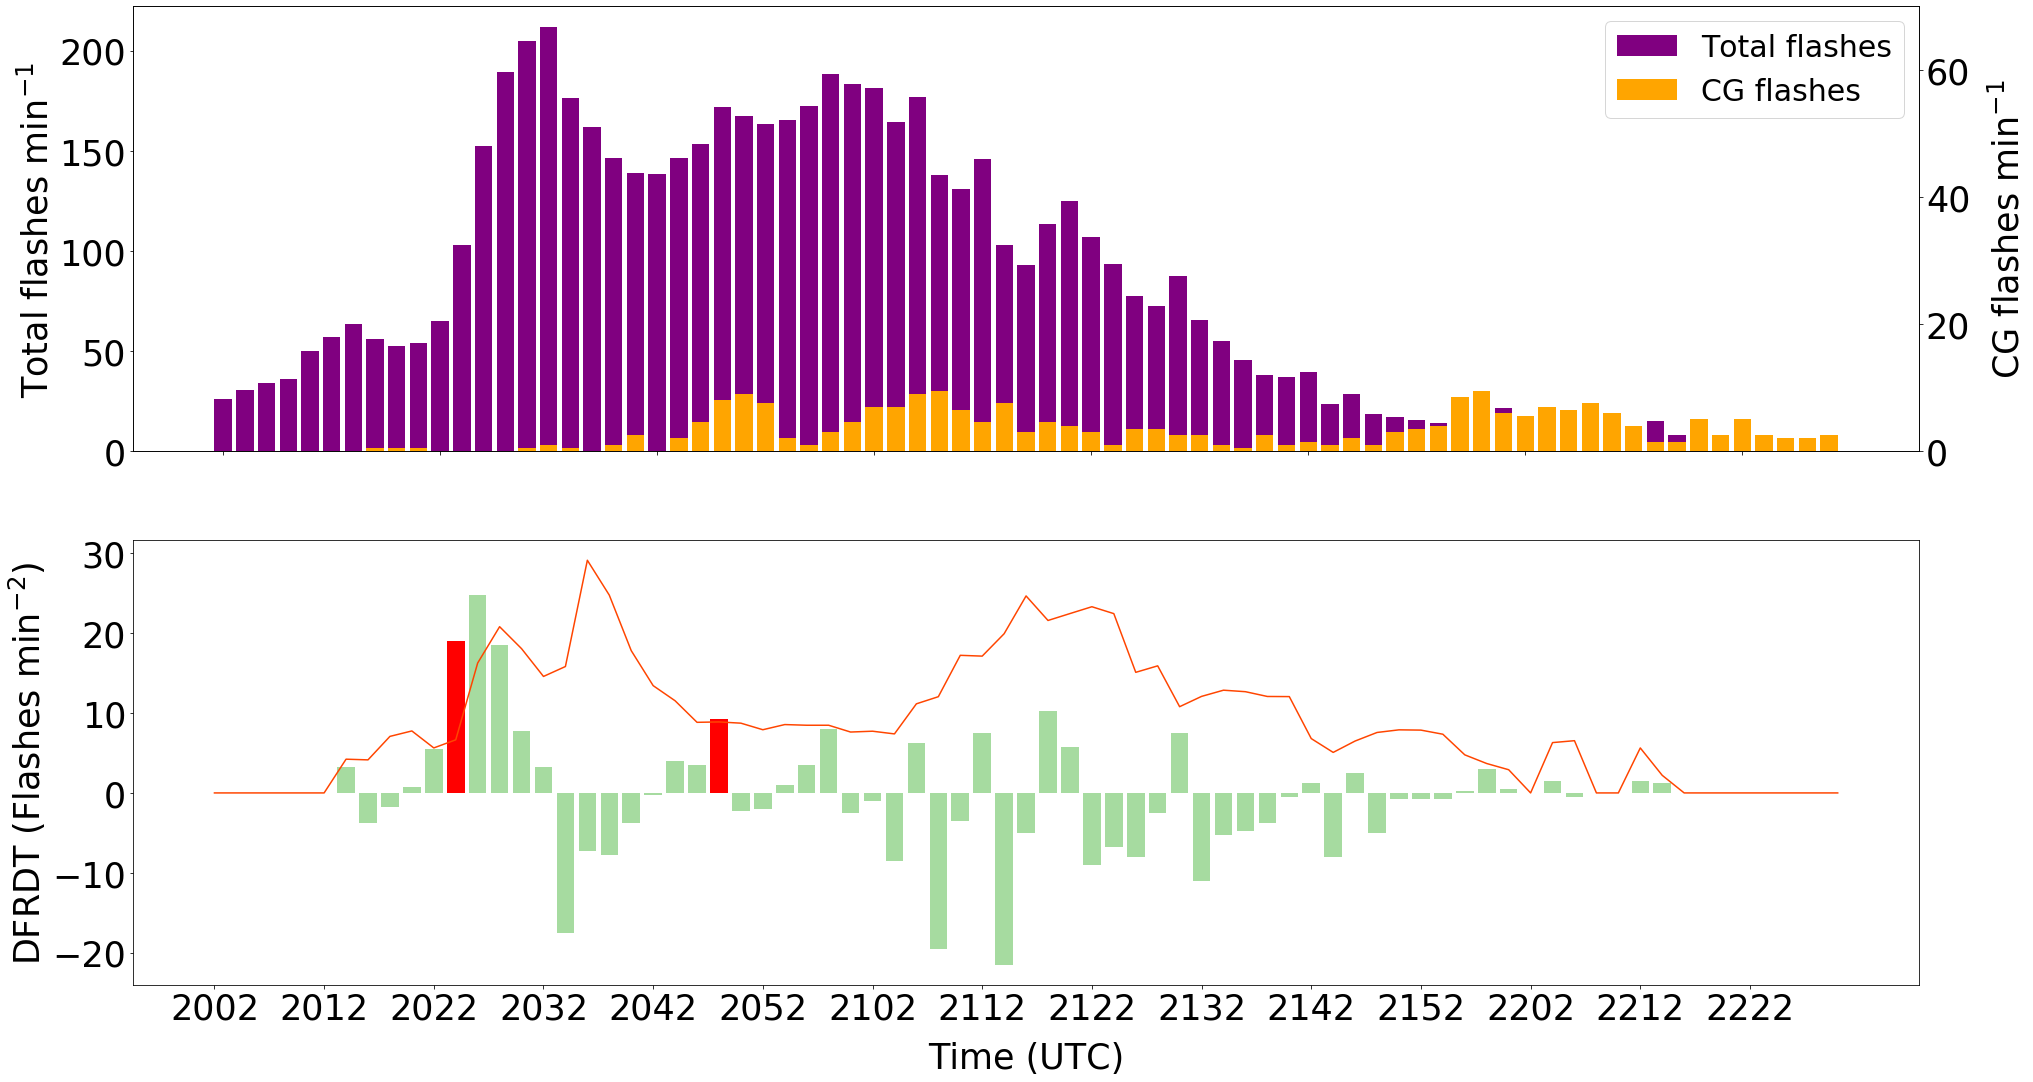

In [10]:
total = final_data.index.value_counts().sort_index()
total1 = total.resample("Min").agg({'sum'})

cg_fr = total1.iloc[:, 0].values

add = []
for i in range(15):
    add.append(0)

cg_frt = add

for i in range(len(cg_fr)):
    cg_frt.append(cg_fr[i])

cg_two_min_avg = [(a + b) / 2 for a, b in zip(cg_frt[::2], cg_frt[1::2])]

plt.rcParams['xtick.labelsize'] = 35
plt.rcParams['ytick.labelsize'] = 35
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['legend.fontsize'] = 30

fig, ax = plt.subplots(2, 1, figsize=(32, 18))
ax[0].bar(np.arange(0, 75, 1), two_min_avg, align='center',
          color='purple', label='Total flashes')
ax[0].tick_params(axis='x', labelbottom=False)
ax[0].set_ylabel('Total flashes min$^{-1}$')

ax2 = ax[0].twinx()
ax2.bar(np.arange(0, 75, 1), cg_two_min_avg,
        align='center', color='orange', label='CG flashes')
ax2.set_ylim(0, 70)
ax2.set_ylabel('CG flashes min$^{-1}$', labelpad=20)
ax[0].bar(np.arange(0, 75, 1), np.nan, color='orange', label='CG flashes')
ax[0].legend(loc=0)

ax[1].plot(threshold, color='orangered')
ax[1].bar(np.arange(0, 75, 1), DFRDT, align='center', color='#a6dba0')
ax[1].bar(idx_lja[0::2], lja_DFRDT[0::2], align='center', color='r')
ax[1].set_xticks(np.arange(0, 75, 5))
ax[1].set_xticklabels(tims_f[::5])
ax[1].set_ylabel('DFRDT (Flashes min$^{-2}$)')
ax[1].set_xlabel('Time (UTC)', labelpad=15)

plt.show()